In [1]:
# Bibliotecas que vamos a usar 
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Leer la imagen

In [2]:
img_path = 'BreCaHAD\BreCaHAD\images\Case_1-01.tif'
groudtruth_path = 'BreCaHAD\BreCaHAD\groundTruth\Case_1-01.json'

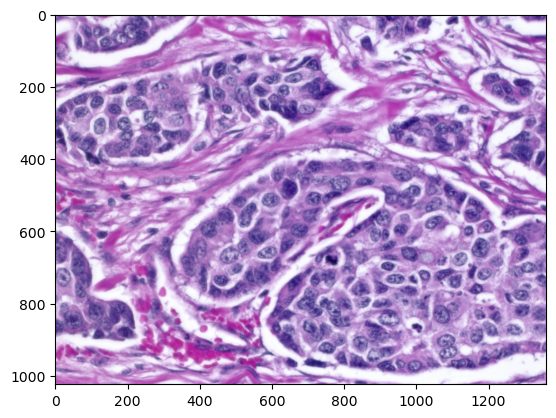

In [3]:
# Leer imágenes 
img1 = cv2.imread(img_path)

# Cambiar de BGR a RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# Mostrar la imagen
plt.imshow(img1)

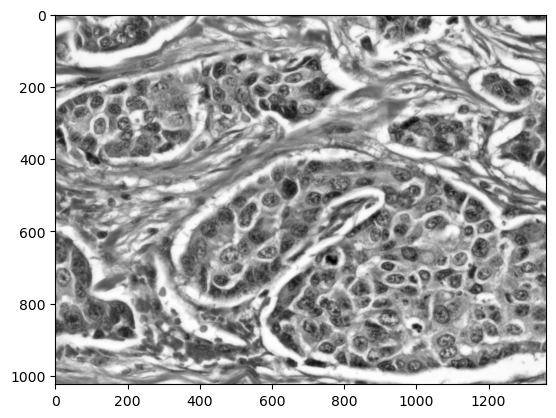

In [4]:
#Transformar a escala de grises 
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
plt.imshow(img1_gray,  cmap='gray')

# Extraer canal azul 

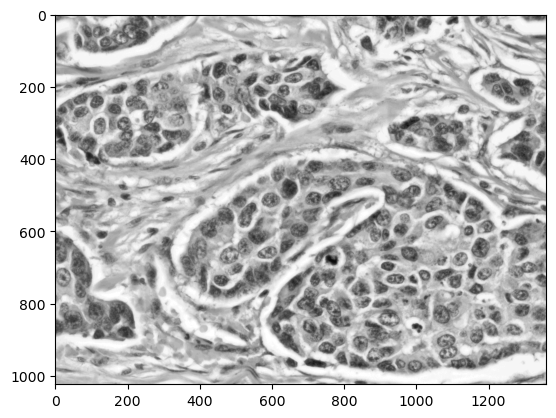

In [5]:
blue_channel = img1[:, :, 0]  # 0 corresponde al canal azul

# Crear una imagen en negro con el mismo tamaño que la original
blue_img = np.zeros_like(img1)

#Asignar el canal azul a la imagen
blue_img[:, :, 0] = blue_channel  
# establecer los canales verde y rojo en 0 (negro)
blue_img[:, :, 1] = 0 
blue_img[:, :, 2] = 0 

blue_img = cv2.cvtColor(blue_img, cv2.COLOR_BGR2GRAY)

plt.imshow(blue_img, cmap = 'gray')

In [6]:
# Mínimo y máximo en imagen en escala de grises 
# blue_img.min()
blue_img.max()

29

In [7]:
img_nuclei = blue_img.copy()
img_nuclei[img_nuclei < blue_img.max()/2 + 1] = 0 # menos a 15 en negro
img_nuclei[img_nuclei >= blue_img.max()/2 + 1] = 255

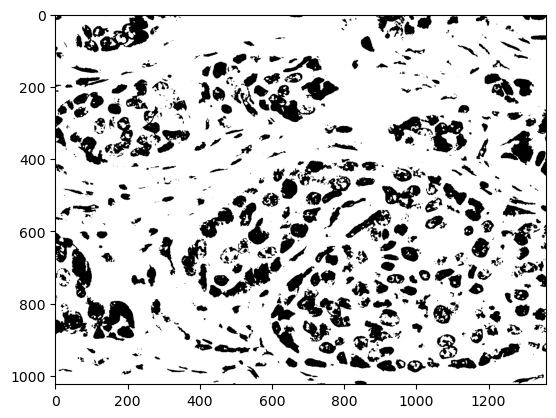

In [8]:
plt.imshow(img_nuclei, cmap = 'gray')

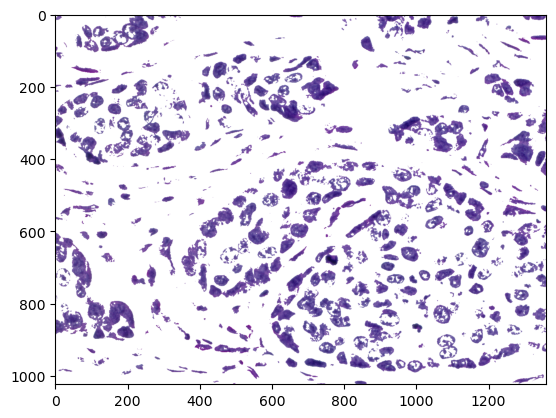

In [9]:
# Para ver a color las partes seleccionadas
img_selected = img1.copy()
img_selected[(img_nuclei == 255) == True] = 255
plt.imshow(img_selected) # Básicamente no hay eosina

In [10]:
# Necesitamos que los núcleos sean blancos y el fondo negro
nuclei_foreground = img_nuclei.copy()
nuclei_foreground[nuclei_foreground == 255 ] = 100
nuclei_foreground[nuclei_foreground != 100 ] = 255
nuclei_foreground[nuclei_foreground == 100 ] = 0

# "Foreground"

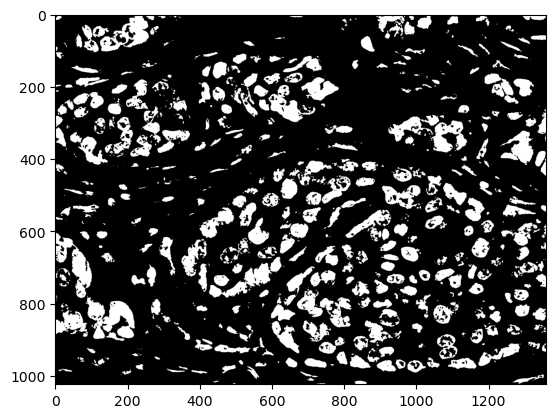

In [11]:
# Este es el "sure foreground" que se usa en la transformación de Watershed
plt.imshow(nuclei_foreground, cmap = "gray")

In [12]:
# Hay muchos espacios a los interno del núcleo, vamos a tratar de llenarlo con operaciones morfológicas 
# Vamos a usar la operación CLOSING para llenar espacios
kernel = np.ones((3,3),np.uint8)
### BORRARRRRR # Primero eliminar ruido

opening = cv2.morphologyEx(nuclei_foreground, cv2.MORPH_OPEN, kernel, iterations = 0)

kernel = np.ones((6,6),np.uint8)
nuclei_foreground_closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations = 1)

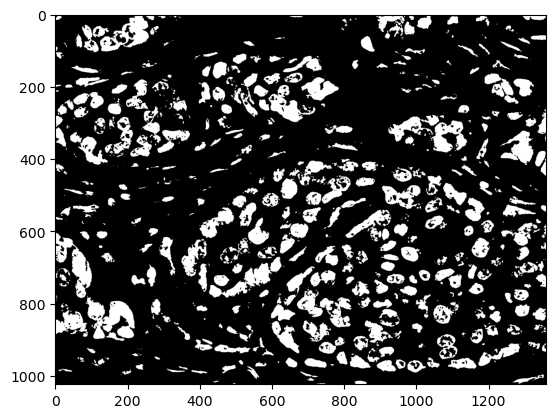

In [13]:
plt.imshow(opening, cmap = "gray")

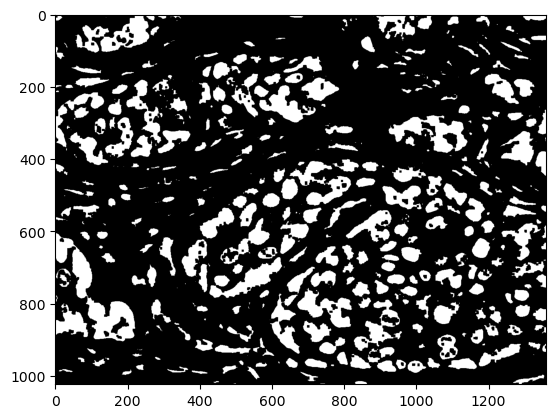

In [14]:
# Para estar más seguros de lo que es "núcleo"
nuclei_foreground_erosion = cv2.erode(nuclei_foreground_closing, kernel, iterations = 0)
plt.imshow(nuclei_foreground_erosion, cmap = "gray")

# Background

In [15]:
# Vamos a a rellanar "más" los espacios para evitar que haya "background" en los nucleos
kernel = np.ones((3,3),np.uint8)
#background = cv2.morphologyEx(nuclei_foreground_closing, cv2.MORPH_CLOSE, kernel, iterations = 5)
background = cv2.dilate(nuclei_foreground_closing,kernel,iterations = 1)

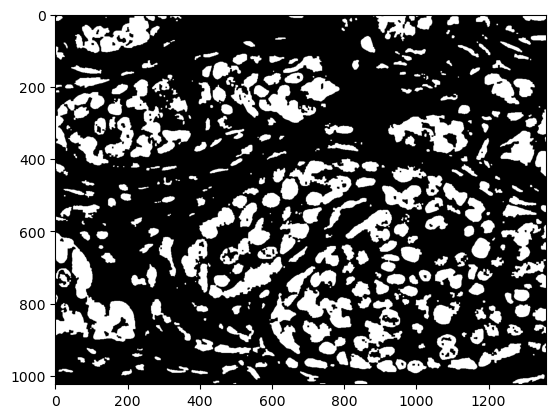

In [16]:
plt.imshow(background, cmap = "gray")

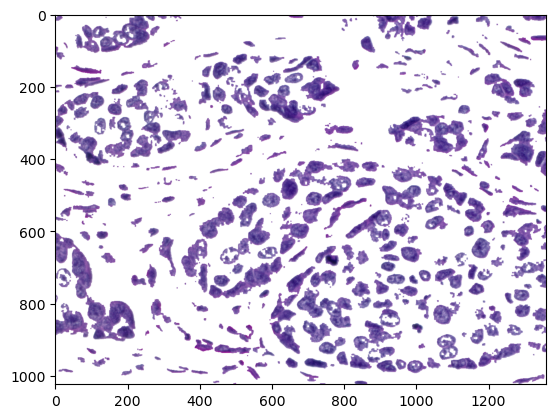

In [17]:
prueba = img1.copy()
prueba[(background == 0) == True] = 255
plt.imshow(prueba)

# Regiones desconocidas

In [18]:
unknow_area = cv2.subtract(background, nuclei_foreground_erosion)

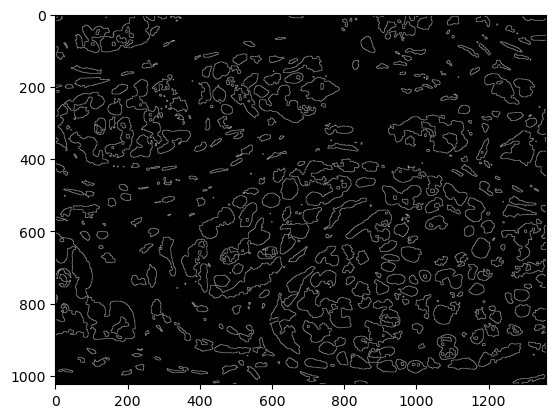

In [19]:
plt.imshow(unknow_area, cmap = "gray")

# Transformada Watershed

In [20]:
# Obtener marcadores
ret, markers = cv2.connectedComponents(nuclei_foreground_erosion)
# Agregamos 1 para que ningún marcador sea 0
markers = markers+1
# Marcamos las regiones desconocidas con 0
markers[unknow_area == 255] = 0

In [21]:
nuclei_segmented = img1.copy()
markers = cv2.watershed(nuclei_segmented, markers)
nuclei_segmented[markers == -1] = [255,0,0]

True

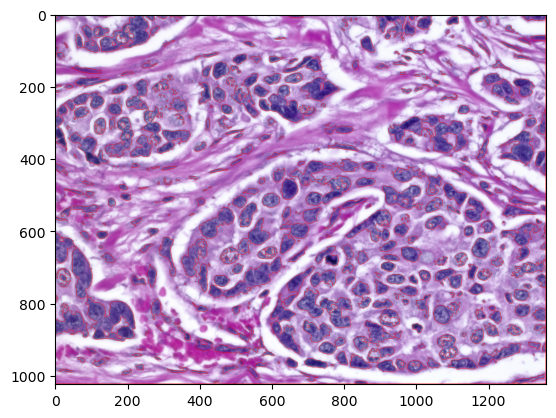

In [22]:
plt.imshow(nuclei_segmented)
nuclei_segmented = cv2.cvtColor(nuclei_segmented, cv2.COLOR_RGB2BGR)
cv2.imwrite('nucleo_water6x6x1.png', nuclei_segmented)

# Núcleos segmentados 

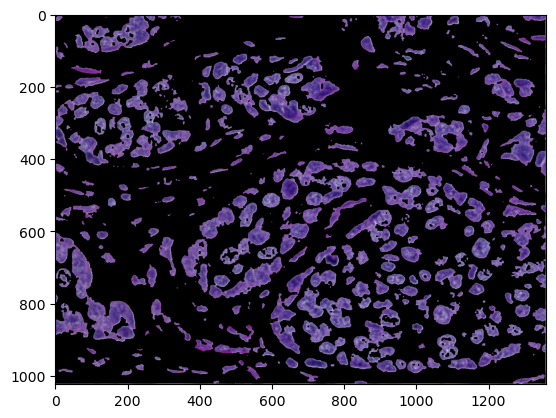

In [23]:
# Obtenemos los núcleos dentro de los bordes 
mask_nuclei = np.zeros_like(img1_gray, dtype=np.uint8)
mask_nuclei[markers != 1] = 255
nuclei_after_water = cv2.bitwise_and(img1, img1, mask=mask_nuclei)
plt.imshow(nuclei_after_water)

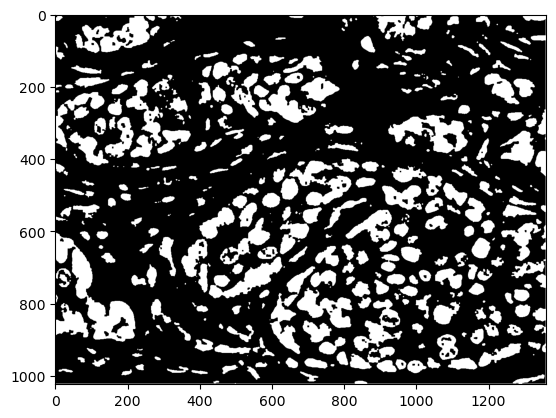

In [24]:
nuclei_white = cv2.cvtColor(nuclei_after_water, cv2.COLOR_RGB2GRAY)
# fondo negro y objetos en blanco
nuclei_white[nuclei_white != 0] = 255
plt.imshow(nuclei_white, cmap = "gray")

# Componentes conectados 

In [25]:
# Parece que el algoritmo que esta usando connectedComponentsWithStats() considera que los objetos en bordes opuestos
# son los mismos. Para correguirlo, vamos a eliminar una pequeña sección de los bordes 


# Eliminar objetos pequeños en los bordes
border_size = 5  # Tamaño del borde para considerar
nuclei_white[:border_size, :] = 0
nuclei_white[-border_size:, :] = 0
nuclei_white[:, :border_size] = 0
nuclei_white[:, -border_size:] = 0

In [26]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(nuclei_white, connectivity = 8)

In [27]:
# Cantidad de componentes conectados
num_labels

470

In [28]:
# Vemos el área de los objetos
stats[:, cv2.CC_STAT_AREA]

array([1034517,     170,   10667,     249,     157,      13,     108,
           206,       4,    4040,     175,      13,    1167,     589,
           714,     624,       5,      47,      24,     185,      13,
            12,     406,     277,      50,      71,      11,      16,
            50,     477,    1153,      44,     130,     330,      20,
             8,     319,      12,     512,      72,     116,     313,
           529,     340,     540,      54,     357,     827,     340,
            90,     359,     498,     237,    2400,     219,       8,
           375,     430,     115,     533,     282,    2003,     300,
           933,     564,     302,       5,     231,      12,     112,
          1034,    1080,    3672,      11,      51,    3873,      91,
             5,     131,       8,      41,      12,       5,    1601,
           283,    4076,      10,     895,    1953,    5800,       5,
           267,       5,    1305,     819,      45,     201,     165,
            75,    1

In [29]:
# Tambien se pueden extraer otras caracteristicas de esos componentes, como:
# Altura del cuadro delimitador 
# stats[:, cv2.CC_STAT_HEIGHT] 

# Ancho del cuadro delimitador
#stats[:, cv2.CC_STAT_WIDTH]

# Los centroides están en variable `centroids`

# Retirar componentes conectados pequeños

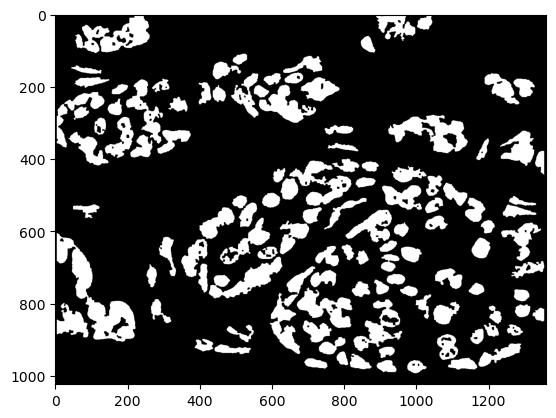

In [30]:
# Definimos un tamaño mínimo
min_size = 800 # ELiminamos los objemos menores a este tamaño

# Generamos un "lienzo" en negro
nuclei_without_smalls = np.zeros((nuclei_white.shape))

for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= min_size:
        nuclei_without_smalls[labels == i] = 255

plt.imshow(nuclei_without_smalls, cmap = 'gray')
        
        

True

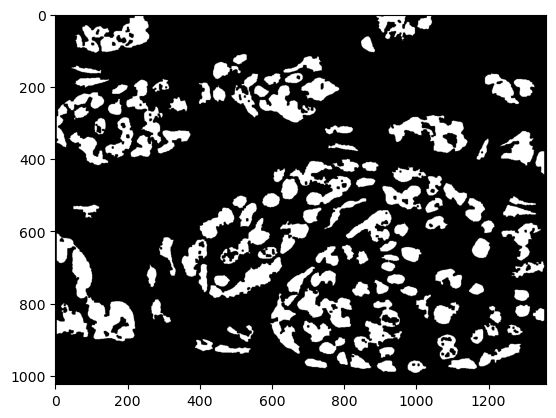

In [31]:
nuclei_with_borders = nuclei_without_smalls.copy()

# Ponemos en negro los bordes obtenidos con Watershed
nuclei_with_borders[markers == -1] = 0
plt.imshow(nuclei_with_borders, cmap = 'gray') # Lo que se gana es poco
cv2.imwrite('nuclei_gray.png', nuclei_with_borders)

# Resultado 

True

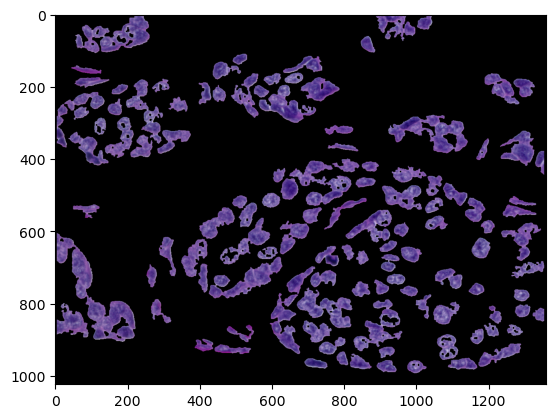

In [32]:
# Núcleos 
nuclei_color = img1.copy()
nuclei_color[(nuclei_without_smalls == 0) == True] = 0
plt.imshow(nuclei_color)
nuclei_color = cv2.cvtColor(nuclei_color, cv2.COLOR_RGB2BGR)
cv2.imwrite('nuclei_color.png', nuclei_color)

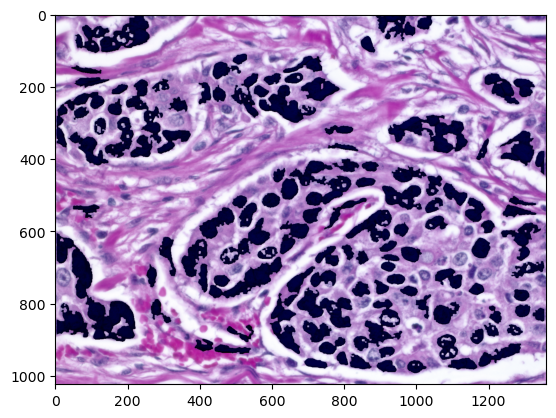

In [33]:
# Fondo
background_color = cv2.subtract(img1, nuclei_color)
plt.imshow(background_color)


# Métricas

## Leer groundTruth

In [34]:
import json

with open(groudtruth_path, 'r') as file:
    # Carga el contenido del archivo JSON
    groundTruth_img1 = json.load(file)

In [35]:
 # Eliminar la clase lumen y non_lumen que forman parte del background
del groundTruth_img1['lumen']
del groundTruth_img1['non_lumen']

In [36]:
img1.shape

(1024, 1360, 3)

In [37]:
img1_points = img1.copy()
nuclei_points = nuclei_color.copy() 
height = img1.shape[0]
width = img1.shape[1]
width

1360

In [38]:
# Asignar un color para cada clase 
cell_color = {
    'mitosis': (0, 0, 255),        # azul
    'non_tumor': (0, 255, 0),    # Verde
    'apoptosis': (255, 0, 0),      # rojo
    'tumor': (255, 255, 0),         # Amarillo
    'non_mitosis': (0, 0, 0),    # Negro
}


## Dibujar y determinar cantidad de núcleos identificados

In [39]:
# Dibujar círculos en la imagen basándote en las coordenadas del JSON
img_with_points =  np.zeros_like(img1)

# extraer valores
total_nuclei_groundTruth = 0
identified_nuclei = 0

for cell_type, nuclei in groundTruth_img1.items():
    color = cell_color.get(cell_type, (255, 255, 255))  # blanco si no está definido
    for point in nuclei:
        x = int(point['x'] * width)
        y = int(point['y'] * height)  # Usar img.shape[0] para obtener la altura
        cv2.circle(img1_points, (x, y), 10, color, -1)  # Dibuja círculos de radio 10 en color rojo (BGR)
        cv2.circle(nuclei_points, (x, y), 10, color, -1)
        cv2.circle(img_with_points, (x,y), 10, (255,255,255) , -1)
        # Cantidad total de núcleos
        total_nuclei_groundTruth +=1
        # Cantidad de ocaciones donde el pixel del "groudtruth" corresponde a un pixel de núcleo
        pixel = nuclei_color[y][x]
        
        if (pixel[0] != 0 and pixel[1] != 0 and pixel[2] != 0):
            identified_nuclei +=1
            
print("La cantidad total de núcleos en el `groundTruth` es", total_nuclei_groundTruth)
print("De eso se segmentaron ", identified_nuclei)
print ("Para un procentaje de", identified_nuclei/total_nuclei_groundTruth*100)
# Este porcentaje es igual a la sencibilidad: 
    # verdaderos_positivos / (verdaderos_positivos + falsos_negativos)
    # identified_nuclei / (identified_nuclei + (total_nuclei_groundTruth - identified_nuclei))
    
        

La cantidad total de núcleos en el `groundTruth` es 141
De eso se segmentaron  121
Para un procentaje de 85.81560283687944


In [40]:
nuclei_points.shape

(1024, 1360, 3)

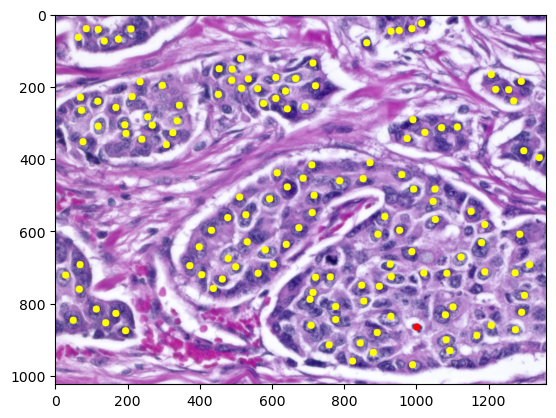

In [41]:
# Mostrar resultado 
plt.imshow(img1_points) # los puntos corresponden al groudtruth

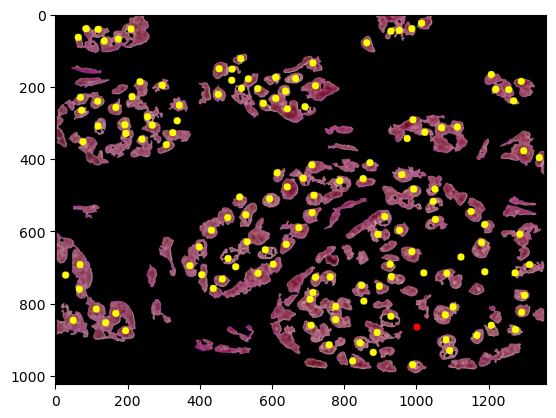

In [42]:
plt.imshow(nuclei_points)

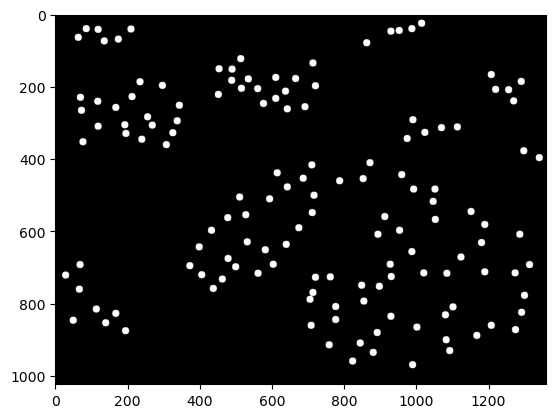

In [43]:
plt.imshow(img_with_points)

## Regiones segmentadas y no presentes en el "groundTruth"

In [44]:
def groundTruth_inside_square(groundTruth, x, y, width, height, image_width, image_height):
    for cell_type, nuclei in groundTruth.items():
        for point in nuclei:
            pixel_x = int(point['x']*image_width)
            pixel_y = int(point['y']*image_height)
            if (x <= pixel_x <= x + width) and (y <= pixel_y <= y + height):
                return True
                break
    return False 

La cantidad de objetos segmentados fue 117
De esos 36 no estaban en el `groudtruth` 


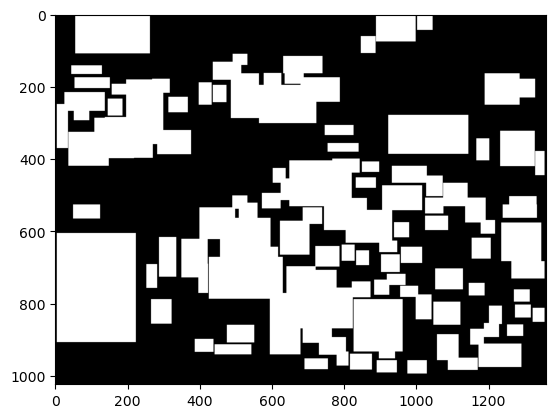

In [45]:
nuclei_without_smalls_8u = nuclei_without_smalls.astype(np.uint8) #necesita que sean enteros sin signo
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(nuclei_without_smalls_8u, connectivity = 8)

n_nuclei_segmented = 0
not_in_groud_truth = 0

squere_components = np.zeros_like(img1)
# Dibujar el cuadro delimitador de cada componente conectado
for i in range(1, num_labels):  # Empezar desde 1 para omitir el fondo (etiqueta 0)
    x, y, w, h, area = stats[i]
    n_nuclei_segmented += 1
    if (not groundTruth_inside_square(groundTruth_img1, x, y, w, h, width, height)):
        not_in_groud_truth += 1
        
    # Dibujar un cuadrado delimitador en el lienzo
    cv2.rectangle(squere_components, (x, y), (x+w, y+h), (255, 255, 255), -1)
plt.imshow(squere_components)

print("La cantidad de objetos segmentados fue", n_nuclei_segmented)
print("De esos", not_in_groud_truth , "no estaban en el `groudtruth` ")

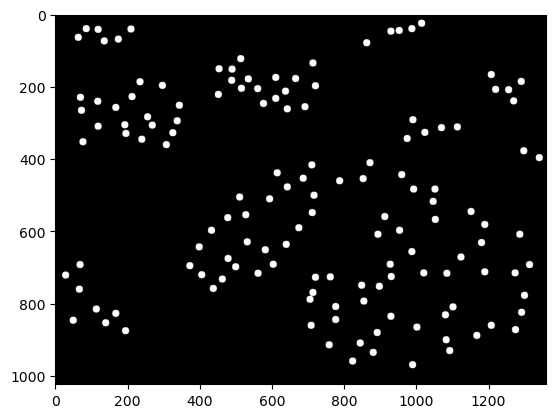

In [46]:
plt.imshow(img_with_points)

## Precisión / Especificidad

In [47]:
# verdaderos_positivos / (verdaderos_positivos + falsos_positivos)
identified_nuclei / (identified_nuclei + not_in_groud_truth)

0.7707006369426752

## Sencibilidad

In [48]:
identified_nuclei / (identified_nuclei + (total_nuclei_groundTruth - identified_nuclei))

0.8581560283687943

# Anexos 

In [49]:
# Métricas para imagenes de prueba fueron
# Case_1-01.tif | Precisión: 0.7555555555555555 |  sencibilidad: 0.9645390070921985
# Case_1-03.tif | Precisión: 0.7978723404255319  |  sencibilidad: 0.8771929824561403
# Case_1-03.tif | Precisión: 0.770949720670391 |  sencibilidad: 0.9019607843137255
# Case_1-04.tif | Precisión: 0.7536231884057971 |  sencibilidad:0.9043478260869565
# Case_1-05.tif | Precisión: 0.7441860465116279 |  sencibilidad: 0.9552238805970149
# Case_1-06.tif | Precisión: 0.7479338842975206 |  sencibilidad: 0.8916256157635468
# Case_1-07.tif | Precisión: 0.871244635193133 |  sencibilidad: 0.8982300884955752
# Case_1-08.tif | Precisión: 0.76 |  sencibilidad: 0.957983193277311
